In [1]:
# Exploratory notebook for the UK 2016 Road Safety Dataset to investigate prediction 
# capability for cycling accidents

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="white")

from datetime import datetime

from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import load_model

from sklearn.model_selection import train_test_split

/home/anurag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
accident_data = pd.read_csv('/home/anurag/ML/Logistic_Regression/uk-2016-road-safety-data/dftRoadSafety_Accidents_2016.csv', dtype={"Did_Police_Officer_Attend_Scene_of_Accident": int})

/home/anurag/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
accident_data.head()
#len(accident_data)
accident_data.tail()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Month_of_Year,Hour_of_Day
136616,2016984130916,319273.0,574564.0,-3.265390,55.058998,98,3,2,1,28/10/2016,...,4,1,2,0,0,2,1,NaN,10,6
136617,2016984131116,316143.0,568615.0,-3.312631,55.005033,98,3,2,2,01/11/2016,...,1,1,1,0,0,2,1,NaN,11,16
136618,2016984131216,322903.0,573365.0,-3.208249,55.048803,98,3,1,1,27/10/2016,...,6,1,2,0,0,2,1,NaN,10,7
136619,2016984131316,318673.0,566850.0,-3.272584,54.989597,98,3,1,3,29/10/2016,...,4,1,1,0,0,2,1,NaN,10,20
136620,2016984133416,308165.0,602737.0,-3.448392,55.310151,98,3,1,2,25/12/2016,...,1,5,2,0,0,2,1,NaN,12,12


In [27]:
date =  '2010-01-31'
dmyyyy = datetime.strptime(date, '%Y-%m-%d')
print(dmyyyy)
print(datetime.strftime(dmyyyy, '%m'))

2010-01-31 00:00:00
01


In [23]:
accident_data.loc[:5 , 'Date' : 'Pedestrian_Crossing-Human_Control']

,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control
0,01/11/2016,3,02:30,28,E09000005,3,4006,6,30.0,0,-1,-1,0,0
1,01/11/2016,3,00:37,18,E09000004,3,207,6,30.0,9,4,6,0,0
2,01/11/2016,3,01:25,26,E09000017,3,4020,1,30.0,1,4,3,4020,0
3,01/11/2016,3,09:15,22,E09000024,3,217,6,30.0,3,2,3,217,0
4,01/11/2016,3,07:53,25,E09000018,3,312,3,40.0,0,-1,-1,0,0
5,01/11/2016,3,09:29,20,E09000008,3,23,6,30.0,3,4,6,0,0


In [28]:
# Extract month from date
def month_from_date(date):
    dmyyyy = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(dmyyyy, '%m'))

accident_data['Month_of_Year'] = accident_data['Date'].apply(month_from_date)

# Extract hour from time
def hour_from_time(time):
    try:
        hhmm = datetime.strptime(time, '%H:%M')
        return int(datetime.strftime(hhmm, '%H'))
    except Exception:
        # Some times are nan
        return 0
    

In [29]:
accident_data['Hour_of_Day'] = accident_data['Time'].apply(hour_from_time)


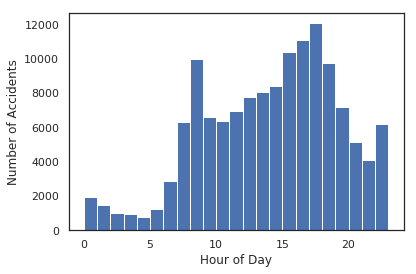

In [33]:
#print(accident_data['Hour_of_Day'])
d = accident_data['Hour_of_Day']
plt.hist(d, bins=np.arange(d.min(), d.max()+1))
plt.ylabel('Number of Accidents')
plt.xlabel('Hour of Day');

In [51]:
# Drop columns which cannot be used as predictors of cycling accidents
accident_data = accident_data.drop(['Number_of_Vehicles', 'Local_Authority_(District)', 
                                    'Police_Force', 'Location_Easting_OSGR', 
                                    'Location_Northing_OSGR', 'Speed_limit',
                                    '1st_Road_Class', 'Road_Type', 'Date', 'Time', 
                                    'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 
                                    '2nd_Road_Number', 'Special_Conditions_at_Site', 
                                    'Carriageway_Hazards', 'Number_of_Casualties',
                                    'Pedestrian_Crossing-Physical_Facilities', 
                                    'Pedestrian_Crossing-Human_Control',
                                    'Did_Police_Officer_Attend_Scene_of_Accident', 
                                    'Local_Authority_(Highway)', 
                                    'LSOA_of_Accident_Location', 'Accident_Severity', 
                                    '1st_Road_Number'], axis=1)

# Remove rows where latitude or longitude is NaN
accident_data = accident_data_cycle[np.isfinite(accident_data['Longitude'])]
accident_data = accident_data_cycle[np.isfinite(accident_data['Latitude'])]

accident_data.head()

/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Accident_Index,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day
0,2016010000005,-0.279323,51.584754,3,5,1,1,1,11,2
1,2016010000006,0.184928,51.449595,3,4,1,1,1,11,0
2,2016010000008,-0.473837,51.543563,3,4,1,1,1,11,1
3,2016010000016,-0.164442,51.404958,3,1,1,1,1,11,9
4,2016010000018,-0.406580,51.483139,3,1,1,1,1,11,7


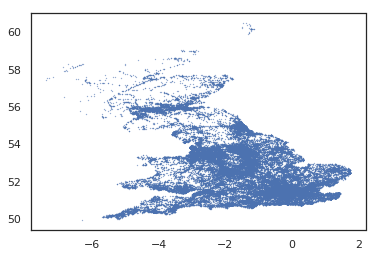

In [52]:
# Plot the accident coordinates
plt.plot(accident_data.Longitude, accident_data_cycle.Latitude, 'b.', ms=0.5)


In [53]:
print ("There are", len(accident_data.index), "unique accidents")

There are 136614 unique accidents


In [39]:
# Read in the casualty data
casualty_data = pd.read_csv('/home/anurag/ML/Logistic_Regression/uk-2016-road-safety-data/Cas.csv')
casualty_data.head()
#len(casualty_data)
casualty_data.tail()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
181379,2016984131316,1,1,1,1,17,4,3,0,0,0,0,0,9,1,6
181380,2016984131316,1,2,2,1,17,4,3,0,0,1,0,0,9,-1,-1
181381,2016984131316,1,3,2,1,21,5,3,0,0,2,0,0,9,1,1
181382,2016984133416,1,1,1,1,48,8,3,0,0,0,0,0,9,1,-1
181383,2016984133416,1,2,2,2,48,8,3,0,0,1,0,0,9,1,-1


In [45]:
casualty_data_cycle = casualty_data[casualty_data.Casualty_Type == 1]
casualty_data_cycle.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
4,2016010000018,2,1,1,1,28,6,3,0,0,0,0,0,1,1,6
17,2016010000046,1,1,1,1,20,4,3,0,0,0,0,0,1,1,2
29,2016010000058,1,1,1,1,23,5,3,0,0,0,0,0,1,1,2
35,2016010000069,2,1,1,1,29,6,3,0,0,0,0,0,1,1,5
36,2016010000072,2,1,1,1,24,5,3,0,0,0,0,0,1,1,6


In [46]:
casualty_data_cycle = casualty_data_cycle.drop(['Bus_or_Coach_Passenger', 'Car_Passenger', 
                                    'Pedestrian_Movement', 'Pedestrian_Location', 
                                    'Casualty_Reference', 'Vehicle_Reference', 
                                    'Casualty_Class', 'Age_of_Casualty',  
                                    'Casualty_Severity', 'Casualty_IMD_Decile', 
                                    'Pedestrian_Road_Maintenance_Worker'], axis=1)
casualty_data_cycle.head()

,Accident_Index,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
4,2016010000018,1,6,1,1
17,2016010000046,1,4,1,1
29,2016010000058,1,5,1,1
35,2016010000069,1,6,1,1
36,2016010000072,1,5,1,1


In [47]:
print ("There are", len(casualty_data_cycle.index), "cycling casualties")

There are 18477 cycling casualties


In [54]:
# Merge accident and casualty data for cycling accidents
casualty_and_accident_data = pd.merge(accident_data, casualty_data_cycle, on='Accident_Index', 
                                      how='left')
casualty_and_accident_data = casualty_and_accident_data.drop(['Accident_Index'], axis=1)

In [57]:
casualty_and_accident_data.head()
#len(casualty_and_accident_data)

,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,5,1,1,1,11,2,NaN,NaN,NaN,NaN
1,0.184928,51.449595,3,4,1,1,1,11,0,NaN,NaN,NaN,NaN
2,-0.473837,51.543563,3,4,1,1,1,11,1,NaN,NaN,NaN,NaN
3,-0.164442,51.404958,3,1,1,1,1,11,9,NaN,NaN,NaN,NaN
4,-0.406580,51.483139,3,1,1,1,1,11,7,1.0,6.0,1.0,1.0


In [58]:
# Replace NaN with zero
casualty_and_accident_data.fillna(0, inplace=True)

# Casualty data after merge is cast to float. Cast back to integer
casualty_and_accident_data['Casualty_Type'] = casualty_and_accident_data['Casualty_Type'].astype(int)

In [59]:
casualty_and_accident_data.head()

,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,5,1,1,1,11,2,0.0,0.0,0,0.0
1,0.184928,51.449595,3,4,1,1,1,11,0,0.0,0.0,0,0.0
2,-0.473837,51.543563,3,4,1,1,1,11,1,0.0,0.0,0,0.0
3,-0.164442,51.404958,3,1,1,1,1,11,9,0.0,0.0,0,0.0
4,-0.406580,51.483139,3,1,1,1,1,11,7,1.0,6.0,1,1.0


In [60]:
# We will use Casualty_Type as an indicator of a cycling accident. If 1 it is a cycling accident and if 0 a non-cycling accident
casualty_and_accident_data = casualty_and_accident_data.rename(columns={'Casualty_Type': 'Cycling_Accident'})

# Display our data
casualty_and_accident_data



,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,5,1,1,1,11,2,0.0,0.0,0,0.0
1,0.184928,51.449595,3,4,1,1,1,11,0,0.0,0.0,0,0.0
2,-0.473837,51.543563,3,4,1,1,1,11,1,0.0,0.0,0,0.0
3,-0.164442,51.404958,3,1,1,1,1,11,9,0.0,0.0,0,0.0
4,-0.406580,51.483139,3,1,1,1,1,11,7,1.0,6.0,1,1.0
5,-0.121004,51.387813,3,1,1,1,1,11,9,0.0,0.0,0,0.0
6,-0.162234,51.517333,3,1,1,1,1,11,8,0.0,0.0,0,0.0
7,-0.213859,51.590341,3,1,1,1,1,11,10,0.0,0.0,0,0.0
8,-0.205302,51.510716,3,1,1,1,1,11,9,0.0,0.0,0,0.0
9,0.023193,51.453758,3,1,1,1,1,11,9,0.0,0.0,0,0.0


In [61]:
# Age_Band_of_Casualty
#
# 1: 0-5
# 2: 6-10
# 3: 11-15
# 4: 16-20
# 5: 21-25
# 6: 26-35
# 7: 36-45
# 8: 46-55
# 9: 56-65
# 10: 66-75
# 11: >75
# -1: Unknown

# Sex_of_Casualty
#
# 1: Male
# 2: Femals
# -1: Unknown

# Casualty_Severity
#
# 1: Fatal
# 2: Serious
# 3: Slight

# Day_of_Week
#
# 1: Sunday
# 2: Monday
# 3: Tuesday
# 4: Wednesday
# 5: Thursday
# 6: Friday
# 7: Saturday

# Road_Surface_Conditions
#
# 1: Dry
# 2: Wet / damp
# 3: Snow
# 4: Frost / ice
# 5: Flood
# 6: Oil
# 7: Mud
# -1: No data

# Cycling_Accident
#
# 1: Yes
# 0: No

In [62]:
# Convert the latitude and longitude coordinates to area squares
latitude_min = min(casualty_and_accident_data['Latitude'])
latitude_max = max(casualty_and_accident_data['Latitude'])
longitude_min = min(casualty_and_accident_data['Longitude'])
longitude_max = max(casualty_and_accident_data['Longitude'])

# Determine the required step for a given number of areas
latitude_step = (latitude_max - latitude_min) / 1000
longitude_step = (longitude_max - longitude_min) / 1000

# Determine the latitude area
def calc_lat_area(current_lat):
    return int((current_lat - latitude_min) / latitude_step)

# Determine the longitude area
def calc_lon_area(current_lon):
    return int((current_lon - longitude_min) / longitude_step)

# Create new columns with the latitude and longitude areas
casualty_and_accident_data["Latitude_Area"] = list(map(calc_lat_area, casualty_and_accident_data["Latitude"]))
casualty_and_accident_data["Longitude_Area"] = list(map(calc_lon_area, casualty_and_accident_data["Longitude"]))

# Drop the old latitude and logitude columns
casualty_and_accident_data = casualty_and_accident_data.drop(['Longitude', 'Latitude'], axis=1)

# Display our data
casualty_and_accident_data.head()

,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type,Latitude_Area,Longitude_Area
0,3,5,1,1,1,11,2,0.0,0.0,0,0.0,157,777
1,3,4,1,1,1,11,0,0.0,0.0,0,0.0,144,828
2,3,4,1,1,1,11,1,0.0,0.0,0,0.0,153,756
3,3,1,1,1,1,11,9,0.0,0.0,0,0.0,140,789
4,3,1,1,1,1,11,7,1.0,6.0,1,1.0,147,763


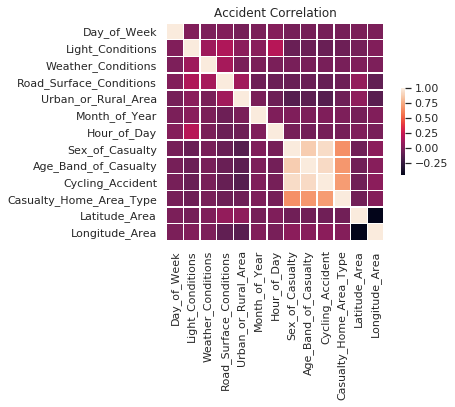

In [63]:
# Compute the correlation matrix
corr = casualty_and_accident_data.corr()

# Draw the correlation matrix
sns.heatmap(corr, square=True, linewidths=.4, cbar_kws={"shrink": .4})

plt.title("Accident Correlation")
plt.show()

In [64]:
# Split the data, 75% for training and 25% for validation
x_data = casualty_and_accident_data.drop(['Cycling_Accident'], axis=1)
y_data = casualty_and_accident_data['Cycling_Accident']

(trainData, testData, trainLabels, testLabels) = train_test_split(x_data.values, 
                                                                  y_data.values, 
                                                                  test_size=0.25, 
                                                                  random_state=42)

In [65]:
y_data.value_counts()

0    118351
1     18476
Name: Cycling_Accident, dtype: int64

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(trainData, trainLabels)

/home/anurag/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_pred = logreg.predict(testData)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(testData, testLabels)))

Accuracy of logistic regression classifier on test set: 1.00


In [85]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testLabels, y_pred)
print(confusion_matrix)

[[29636     0]
 [    5  4566]]


In [87]:
from sklearn.metrics import classification_report
print(classification_report(testLabels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29636
           1       1.00      1.00      1.00      4571

   micro avg       1.00      1.00      1.00     34207
   macro avg       1.00      1.00      1.00     34207
weighted avg       1.00      1.00      1.00     34207



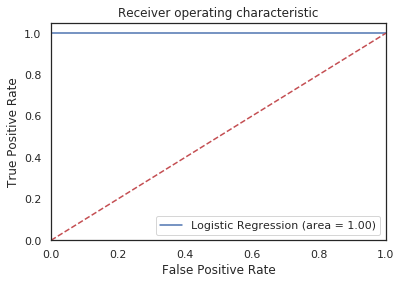

In [88]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(testLabels, logreg.predict(testData))
fpr, tpr, thresholds = roc_curve(testLabels, logreg.predict_proba(testData)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [89]:
# Setup our Keras model
model = Sequential()
model.add(Dense(2000, input_dim=12, kernel_initializer="uniform", activation="relu"))
model.add(Dense(500))
model.add(Dense(80))
model.add(Dense(1))
model.add(Activation("sigmoid"))

# Train the model using SGD
sgd = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=4, batch_size=30, verbose=1)

Epoch 1/4
102620/102620 [==============================] - 44s 432us/step - loss: 2.1837 - acc: 0.8644
Epoch 2/4
102620/102620 [==============================] - 40s 386us/step - loss: 2.1840 - acc: 0.8645
Epoch 3/4
102620/102620 [==============================] - 38s 366us/step - loss: 2.1840 - acc: 0.8645
Epoch 4/4
102620/102620 [==============================] - 37s 364us/step - loss: 2.1840 - acc: 0.8645


In [90]:
# Evaluate accuracy on testing data set
(loss, accuracy) = model.evaluate(testData, testLabels, batch_size=3, verbose=1)
print("\nloss = {:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

34207/34207 [==============================] - 17s 500us/step

loss = 2.1538, accuracy: 86.6372%


In [91]:
# Accuracy is reported high but in reality we dont have enough cycling accidents for 
# meaningful training
ANN_pred = np.round(model.predict(testData))
ANN_cycling_accident = ANN_pred.astype(int)
ANN_cycling_accident.min()

0

In [92]:
ANN_cycling_accident.max()

0